In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45637,NaN,NaN,International,2020-09-21,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45638,NaN,NaN,International,2020-09-22,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45639,NaN,NaN,International,2020-09-23,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


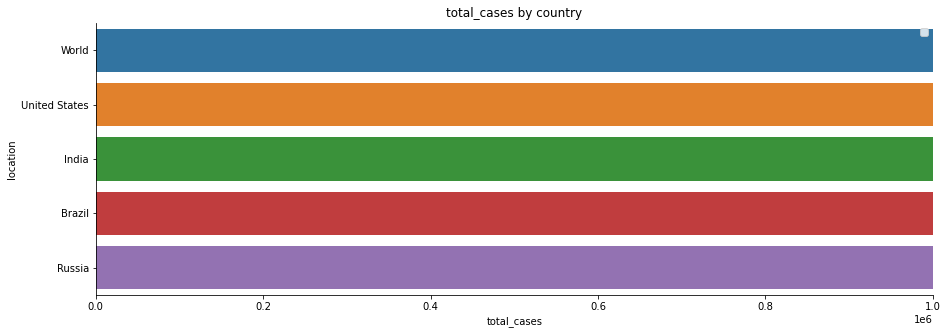

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


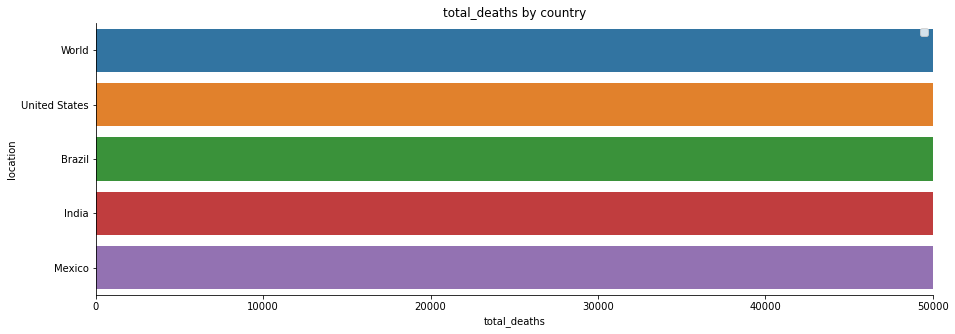

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


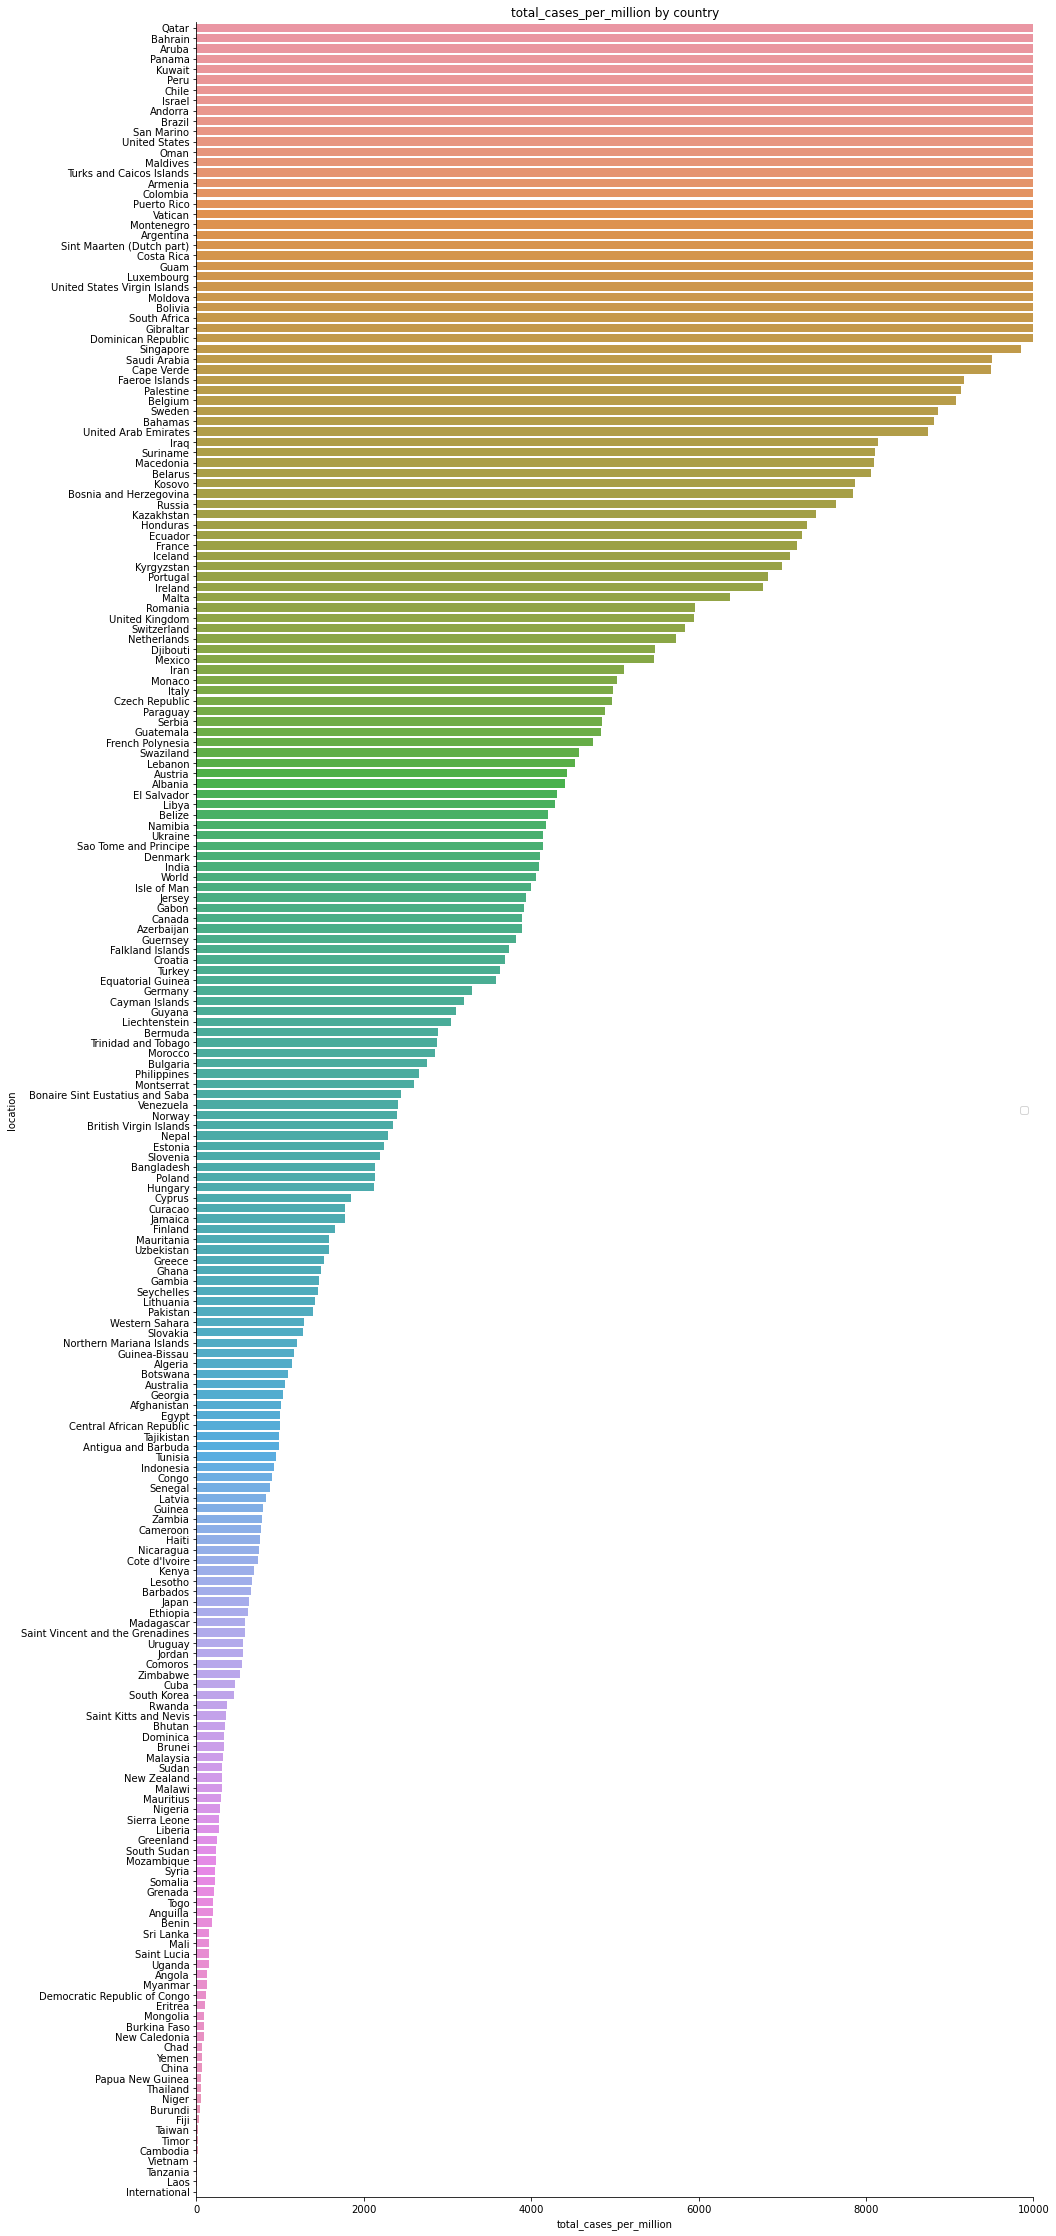

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


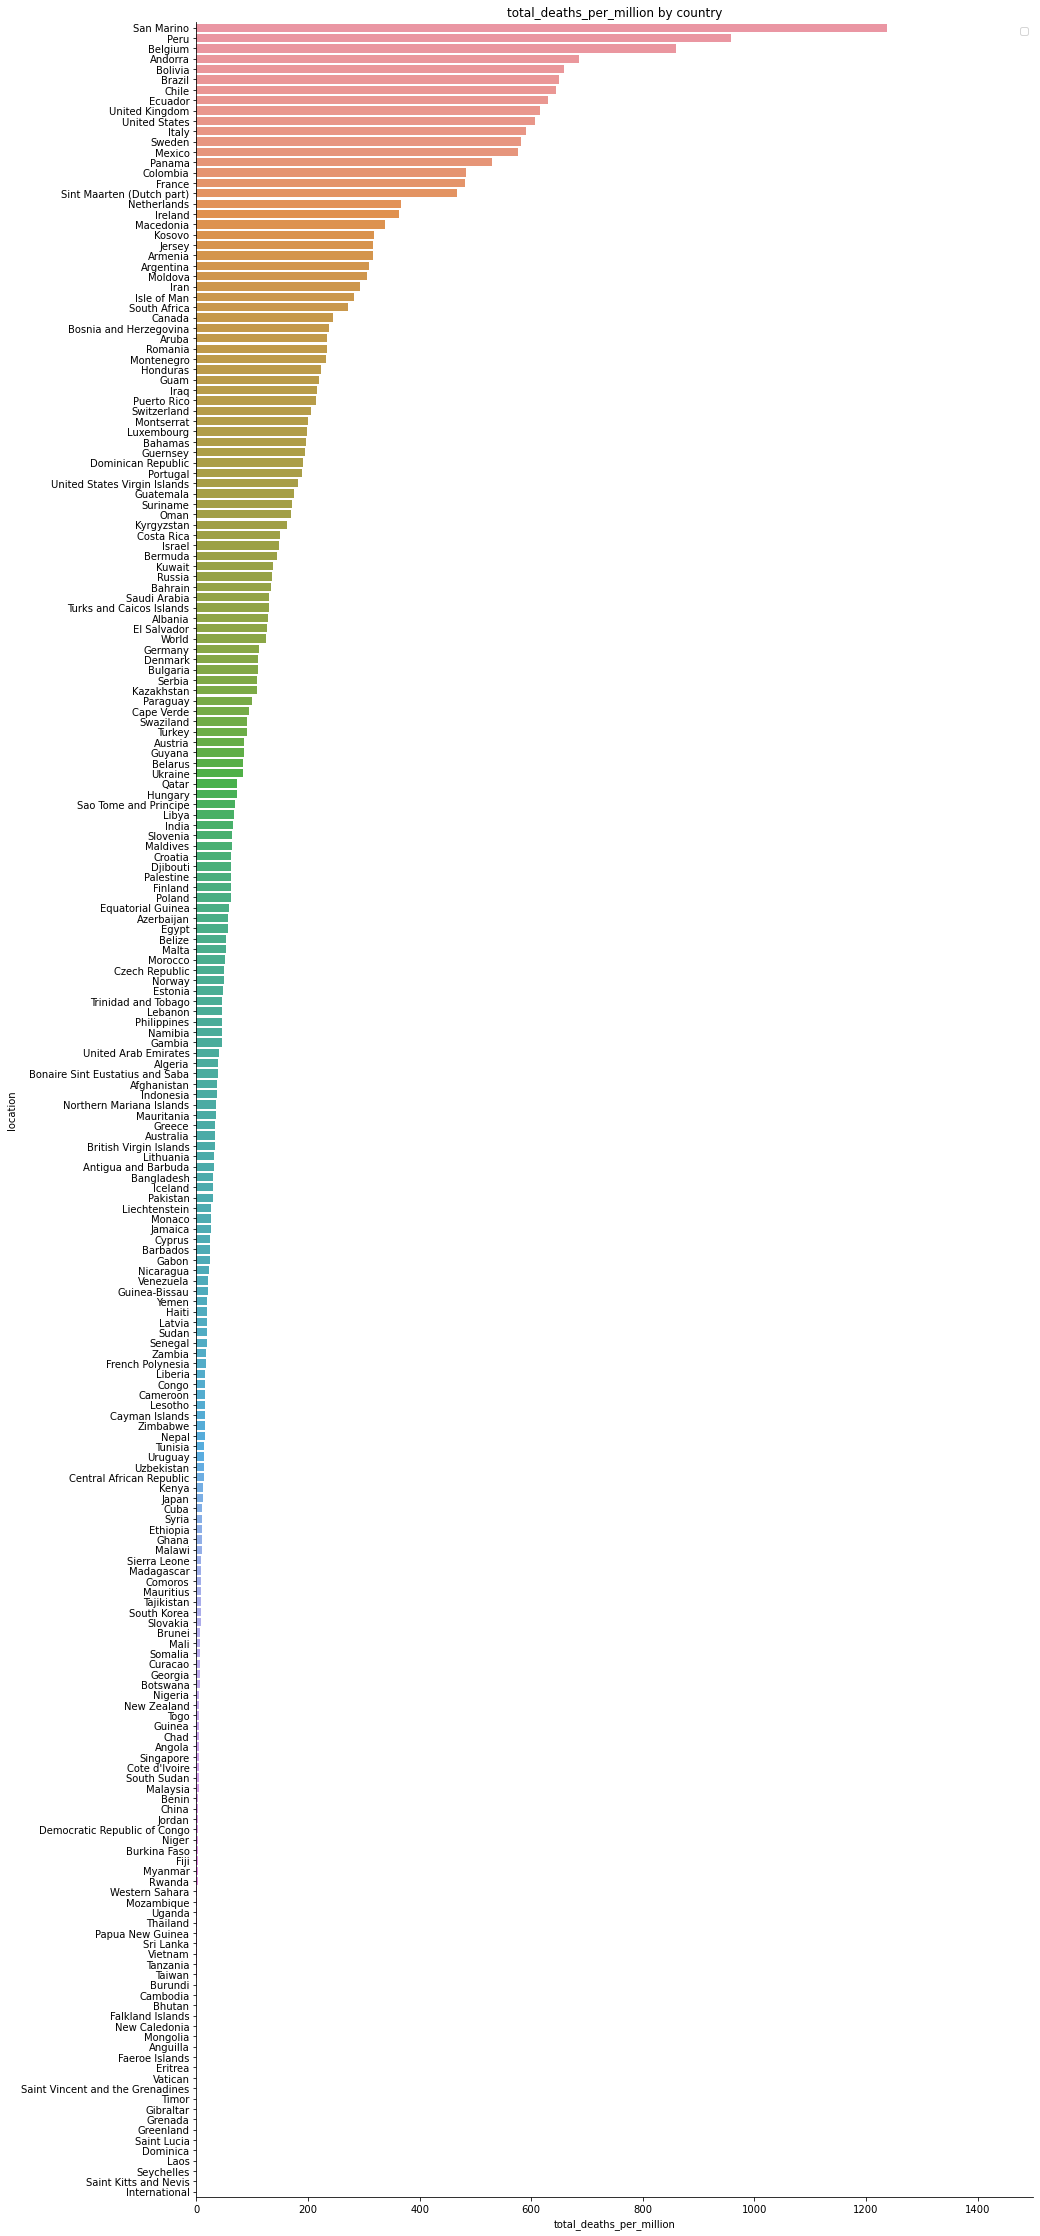

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

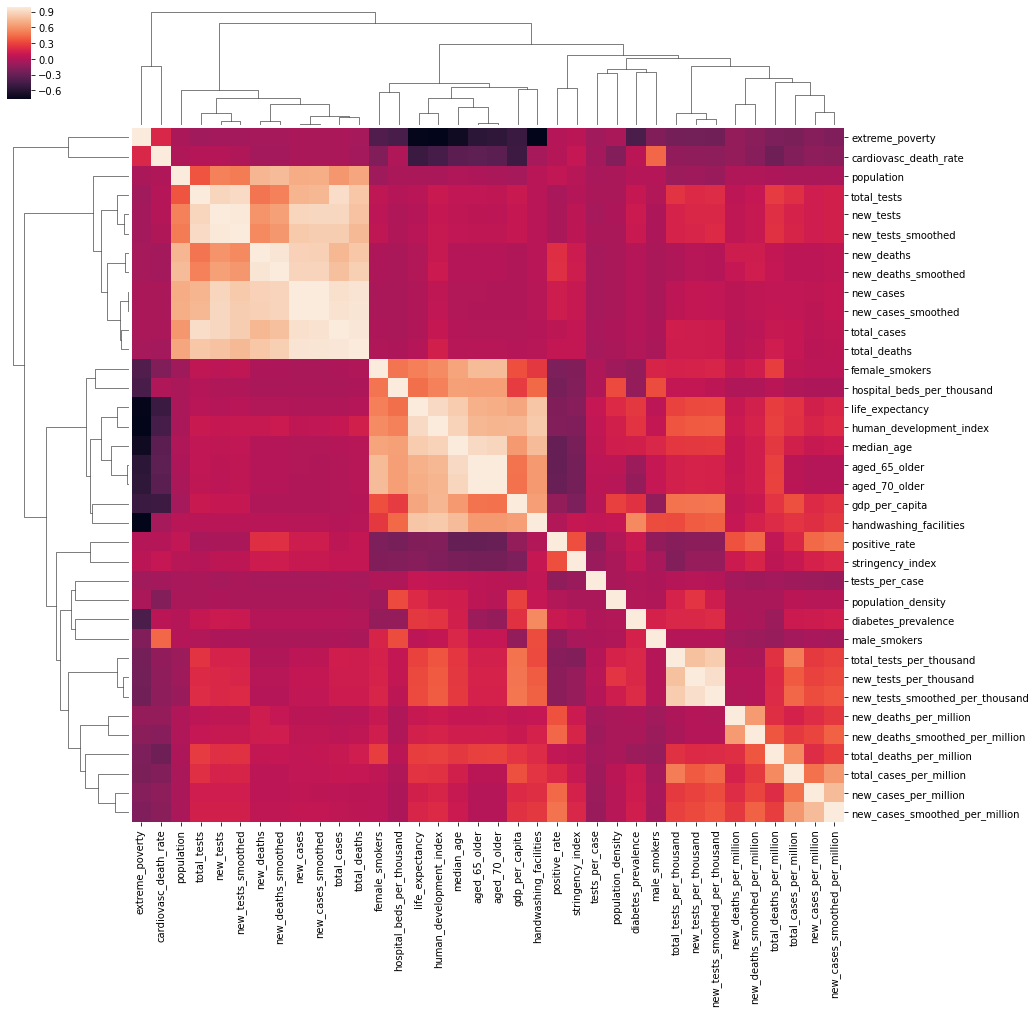

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9985293621582767 (+/- 0.0019009678206968112)
Coef :  [1.03144743e+00 8.17784687e-05 8.48182715e-05]
3 Last_days :  [[31127157 31390886 31658573]]
Today :  31658573
Prediction + :  557344
Tomorow :  32215917
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996264382257455 (+/- 0.00016110564767641593)
Coef :  [0.22068643 0.38311302 0.40614953]
3 Last_days :  [[961542 965932 971869]]
Today :  971869
Prediction + :  8453
Tomorow :  980322
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.13401374411945396 (+/- 1.6000605793168585)
Coef :  [-0.74077449  0.78910449  0.95667649]
3 Last_days :  [[453763 458061 468069]]
Today :  468069
Prediction + :  5009
Tomorow :  473078
                                     
--------- Total Death -----------------
                                     
R^2: 0.8877440991642135 (+/- 0.14953735432500198)
Coef :  [-0.74587056  0.78764986  0.95719194]
3 Last_days :  [[31285 31338 31416]]
Today :  31416
Prediction + :  57
Tomorow :  31473
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9626777207857954 (+/- 0.03643177911517158)
Coef :  [-0.33011336 -0.01003515  1.33441348]
3 Last_days :  [[90369 90381 90399]]
Today :  90399
Prediction + :  19
Tomorow :  90418
                                     
--------- Total Death -----------------
                                     
R^2: -38.96571706299455 (+/- 56.42030975245142)
Coef :  [-0.07764685  0.01248275  1.05686592]
3 Last_days :  [[4737 4737 4737]]
Today :  4737
Prediction + :  5
Tomorow :  4742
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9304627562014348 (+/- 0.09712586393662066)
Coef :  [-0.8104255   0.89191124  0.91794901]
3 Last_days :  [[298156 299506 300897]]
Today :  300897
Prediction + :  1215
Tomorow :  302112
                                     
--------- Total Death -----------------
                                     
R^2: -0.08094485285360953 (+/- 1.5078097639578467)
Coef :  [-0.81956253  0.89521862  0.92334141]
3 Last_days :  [[35707 35724 35738]]
Today :  35738
Prediction + :  33
Tomorow :  35771
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.569241499388883 (+/- 0.6017782306174839)
Coef :  [-0.25043378  0.13300293  1.12601159]
3 Last_days :  [[640040 671468 682267]]
Today :  682267
Prediction + :  14990
Tomorow :  697257
                                     
--------- Total Death -----------------
                                     
R^2: 0.08960861779655101 (+/- 0.9924628106304786)
Coef :  [-0.72970172  0.64187716  1.08692489]
3 Last_days :  [[30495 30663 30904]]
Today :  30904
Prediction + :  154
Tomorow :  31058
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9648675899162956 (+/- 0.047706082425817795)
Coef :  [0.13568979 0.43646715 0.44044712]
3 Last_days :  [[6804814 6857967 6896274]]
Today :  6896274
Prediction + :  76238
Tomorow :  6972512
                                     
--------- Total Death -----------------
                                     
R^2: 0.9875808579485055 (+/- 0.01628962234206266)
Coef :  [-0.39498915  0.66680717  0.73089667]
3 Last_days :  [[199509 199881 200807]]
Today :  200807
Prediction + :  892
Tomorow :  201699
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994391433356542 (+/- 0.0004901599554357788)
Coef :  [-0.67493268  0.82541327  0.85060238]
3 Last_days :  [[394257 398625 403551]]
Today :  403551
Prediction + :  3204
Tomorow :  406755
                                     
--------- Total Death -----------------
                                     
R^2: 0.24182540279412548 (+/- 1.0348626776233283)
Coef :  [-0.7637132   0.82978692  0.93317032]
3 Last_days :  [[41777 41788 41825]]
Today :  41825
Prediction + :  39
Tomorow :  41864
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.2717327289303366 (+/- 1.0290109676383823)
Coef :  [-0.77400949  0.84700344  0.92697569]
3 Last_days :  [[272337 274158 275927]]
Today :  275927
Prediction + :  1597
Tomorow :  277524
                                     
--------- Total Death -----------------
                                     
R^2: 0.24813520068148195 (+/- 1.055340781162047)
Coef :  [-0.78315969  0.83874392  0.94362081]
3 Last_days :  [[9386 9396 9409]]
Today :  9409
Prediction + :  13
Tomorow :  9422
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9922634066878219 (+/- 0.009165512093964552)
Coef :  [0.35478489 0.32999811 0.32627599]
3 Last_days :  [[422140 425481 429193]]
Today :  429193
Prediction + :  2653
Tomorow :  431846
                                     
--------- Total Death -----------------
                                     
R^2: 0.9119424482688777 (+/- 0.12383610028566201)
Coef :  [0.15899966 0.43200168 0.42010196]
3 Last_days :  [[24301 24478 24656]]
Today :  24656
Prediction + :  211
Tomorow :  24867
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.999508111144007 (+/- 0.00041848679124801663)
Coef :  [-0.62451539  0.79714823  0.82478818]
3 Last_days :  [[302867 304610 306302]]
Today :  306302
Prediction + :  1335
Tomorow :  307637
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990226098243381 (+/- 0.0009549348559948131)
Coef :  [-0.81581595  0.89550724  0.91859671]
3 Last_days :  [[7506 7574 7639]]
Today :  7639
Prediction + :  55
Tomorow :  7694
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8789695833151479 (+/- 0.16734036689925377)
Coef :  [-0.13259162  0.51281257  0.63159797]
3 Last_days :  [[4544629 4558068 4591604]]
Today :  4591604
Prediction + :  51847
Tomorow :  4643451
                                     
--------- Total Death -----------------
                                     
R^2: 0.46060464205972185 (+/- 0.7557240102115421)
Coef :  [-0.03744523  0.4879      0.55962133]
3 Last_days :  [[136895 137272 138108]]
Today :  138108
Prediction + :  1369
Tomorow :  139477
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(31658573, 971869, 32215917, 980322),
 (468069, 31416, 473078, 31473),
 (300897, 35738, 302112, 35771),
 (682267, 30904, 697257, 31058),
 (6896274, 200807, 6972512, 201699),
 (90399, 4737, 90418, 4742),
 (403551, 41825, 406755, 41864),
 (275927, 9409, 277524, 9422),
 (429193, 24656, 431846, 24867),
 (306302, 7639, 307637, 7694),
 (4591604, 138108, 4643451, 139477)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-23,France,473078.0,0.0,31473.0,0.0,0.0,0.0
0,2020-09-23,China,90418.0,0.0,4742.0,0.0,0.0,0.0
0,2020-09-23,Italy,302112.0,0.0,35771.0,0.0,0.0,0.0
0,2020-09-23,Spain,697257.0,0.0,31058.0,0.0,0.0,0.0
0,2020-09-23,United States,6972512.0,0.0,201699.0,0.0,0.0,0.0
0,2020-09-23,World,32215917.0,0.0,980322.0,0.0,0.0,0.0
0,2020-09-23,United Kingdom,406755.0,0.0,41864.0,0.0,0.0,0.0
0,2020-09-23,Germany,277524.0,0.0,9422.0,0.0,0.0,0.0
0,2020-09-23,Iran,431846.0,0.0,24867.0,0.0,0.0,0.0
0,2020-09-23,Turkey,307637.0,0.0,7694.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")